<a href="https://colab.research.google.com/github/mfdali/PermeabilityCircularVugs/blob/main/MVP_Sprint2_ML_Monique_Dali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning: Permeabilidade Equivalente

**MVP 2**

### @author: Monique Dali

### Data Science & Analytics


## 1. Definição do Problema

A base de dados utilizado neste projeto consiste em parâmetros e soluções de simulações numéricas do escoamento de fluidos em lâminas bidimensionais de duas amostras de rocha. O simulador foi implementado por Dali, Gomes e Carvalho no Laboratório de Microhidrodinâmica e Escoamento em Meios Porosos da PUC-Rio, com os objetivos de encontrar uma solução aproximada para a pressão e velocidade ao longo de um domínio com vazios e matriz porosa e calcular sua permeabilidade absoluta. Esta base é composta por imagens tomográficas de 2 amostras de carbonato com cavidades, o qual não possui solução teórica para o escoamento. Com base nessas imagens, outras foram manipuladas virtualmente para obter macroporosidades maiores. Das imagens alguns atributos foram extraídos. O dataset apresenta esses atributos obtidos da imagem, parâmetros de construção do estudo e a permeabilidade absoluta encontrada pela simulação.
Para mais detalhes sobre o estudo que gerou este dataset, o artigo encontra-se disponível em: https://www.researchgate.net/publication/337746813_Equivalent_permeability_in_vuggy_porous_media_using_Brinkman's_model

**Informações sobre os atributos:**
1. **Image_file, Id1, Id2, Slice** - Nome e identificadores da imagem
2. **Sample** - Amostra 5 ou 8
3. **Threshold** - Técnica de manipulação da imagem utilizada, onde 1 representa a imagem binarizada sem manipulações das cavidades.
4. **%Area** - Macroporosidade que representa o percentual que as cavidades ocupam no domínio (%)
5. **K(m2),Keq(m2)** - Permeabilidade da matriz porosa e permeabilidade equivalente (m²)
6. **Delta P(Pa)** - Diferencial de pressão imposto na simulação (Pa)  
7. **Count** - Quantidade de cavidades
8. **Total Area** - Area das cavidade em pixels
9. **Average Size** - Média da cavidade
10. **Perimeter** - Perimetro médio das cavidades
11. **Knorm** - Permeabilidade equivalente dividido pela permeabilidade da matriz porosa. Representa o incremento de permabilidade devido a presença das cavidades.
12. **Direction** - Direção na imagem em que o escoamento foi simulado.


**Exemplo de imagem pertencente a base de dados**

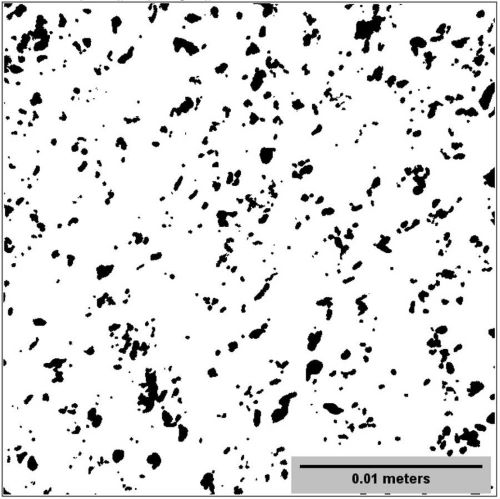

**Extração de atributos da imagem**

Com a biblioteca de análise de imagens scikit-image foi possível medir propriedades de objetos em uma figura rotulada. Utilizamos a função skimage.measure.regionprops_table() para extrair as propiedades de cada componente pertencente a uma imagem e salvar em um arquivo compatível com a biblioteca pandas. Uma nova linha na base de dados é inserida para cada imagem contendo a média ponderada pela área do objeto de cada atributo extraído.

Mais informações da biblioteca utilizada estão disponíveis em: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html

O script de extração de dados encontra-se disponível no GitHub: https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/image_properties.py

# 2. Importando as bibliotecas necessárias

Seção que contém as bibliotecas necessárias para execução do notebook.


### Python libraries

In [194]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # missing treatment
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import math

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 3. Ferramentas

Seção classes e funções utilizadas ao longo do notebook.

Classes and functions

In [195]:
# Classes and functions

class LoadData:

    def load_file(self, url: str):
        """ Load dataset """
        return pd.read_csv(url, delimiter=',', header=0)


class PreProcess:

    def pre_processing(self, dataset, test_size, val_size, random_state):
        """ Database pre-processing """
        # Clean data. Find and ignore outliers

        # Feature selection

        # Split dataframe in train and test data
        X_train, X_test, X_val, y_train, y_test, y_val = self.__prepare_holdout(dataset,
                                                                  test_size, val_size, random_state)

        return (X_train, X_test, X_val, y_train, y_test, y_val)

    def standardization(self, train_var, test_var, seed=42):
      # standardization - rescale data to mean of 0
      sc = StandardScaler()
      v_train = sc.fit_transform(train_var)
      v_test = sc.transform(test_var)

      return (v_train, v_test)

    def normalization(self, train_var, test_var, val_var, seed=42):
      # Normalization - range between 0 and 1
      sc = MinMaxScaler()
      v_train = sc.fit_transform(train_var)
      v_test = sc.transform(test_var)
      v_val = sc.transform(val_var)

      return (v_train, v_test, v_val)

    def __prepare_holdout(self, dataset, test_size=0.2, val_size=0.2, random_state=42):
        """ Split dataframe in train and test set   """

        array = dataset.values
        X = array[:, 0:-1] # Attributes
        Y = array[:, -1] # Target in the last column
        X_train, X_test_val, y_train, y_test_val = train_test_split(X, Y, test_size=test_size, random_state=random_state, shuffle=True)
        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=val_size, random_state=random_state, shuffle=True)
        return X_train, X_test, X_val, y_train, y_test, y_val

    def clean_data(self, dataset):
      # Copy dataset
      cleaned_dataset = dataset

      # transform zeros into NaN values
      cleaned_dataset.replace(0, np.nan, inplace=True)

      # Clean data
      cleaned_dataset = cleaned_dataset[~cleaned_dataset.isnull().any(axis=1)]

      return cleaned_dataset

    def ignore_values(self, dataset, column_header, condition, cut_value):

      if condition is 'bigger':
        ignore_dataset = dataset[dataset[column_header]>=cut_value]
      if condition is 'less':
        ignore_dataset = dataset[dataset[column_header]<=cut_value]
      return ignore_dataset

class FeatureSelection:

    def __init__(self, k_best):
        self.k_best = k_best
        self.feature_selector = None

    def select_features(self, X_train, y_train):
        # Perform feature selection using SelectKBest
        self.feature_selector = SelectKBest(k=self.k_best)
        X_train_selected = self.feature_selector.fit_transform(X_train, y_train)
        best_var = self.feature_selector
        return X_train_selected, best_var


class RegressionModel:

    def train_SVM(self, X_train, Y_train):
        """ Create and train SVM model """
        reg_model = SVR()
        reg_model.fit(X_train, Y_train)
        return reg_model

    def generic_train(self, reg_model, X_train, Y_train):
        """ Create and train SVM model """
        reg_model.fit(X_train, Y_train)
        return reg_model

    def train_models(self, models, X_train, Y_train, kfold):

        # List to hold name and result of each model
        results = []
        names = []
        print("Model:\t MAE_mean\t (MAE_std)\n")
        # Evaluate model
        for name, model in models:
          cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_error')
          results.append(cv_results)
          names.append(name)
          msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std()) # mean and standard deviation
          print(msg)

        return (names,results)

    def hyperparameter_tuning(self, model, X_train, y_train, param_grid, kfold):
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=kfold)
        grid_search.fit(X_train, y_train)

        return grid_search.best_estimator_,grid_search.best_score_, grid_search.best_params_

class Evaluate:

    def eval_accuracy(self, reg_model, X_test, Y_test):
        """ Predicts and evaluate the model """
        predictions = reg_model.predict(X_test)
        mae = mean_absolute_error(Y_test, predictions)
        mse = mean_squared_error(Y_test, predictions)
        rmse = np.sqrt(abs(mse))
        r2 = r2_score(Y_test, predictions)
        print("MAE:%0.2f\t MSE:%0.2f\t RMSE:%0.2f\t R2:%0.2f\n" % (mae,mse,rmse,r2))

        return predictions

    def singlerow_boxplot(self, dataset):
      ''' Create a single row boxplot for every numeric columns on dataframe '''
      # Get columns with type of data numeric
      values_headers = dataset._get_numeric_data().columns.tolist()
      df = dataset[values_headers]

      #Creating subplot of each column with its own scale
      red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

      fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))

      for i, ax in enumerate(axs.flat):
          ax.boxplot(df.iloc[:,i], flierprops=red_circle)
          ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
          ax.tick_params(axis='y', labelsize=14)

      plt.tight_layout()
      plt.show()



In [196]:
# Calling Classes
load = LoadData()
pre_process = PreProcess()
select_model = RegressionModel()
evaluation = Evaluate()

# 2. Carga de Dados

Dois arquivos serão carregados e unidos para formar uma base com dados retirados da imagem e dados provenientes da simulação numérica de fluidos através de lâminas de rochas carbonáticas.
A partir do github carregamos dois arquivos .csv que contém cabeçalhos através do pacote Pandas.


In [6]:
# Parameters
np.random.seed(42) # definindo uma semente global
test_size = 0.2 # Percentual of occurencies reserved to test the model
val_size = 0.2 # Percentual of occurencies reserved to validate the model
random_state = 42 # Seed

# Fist dataframe containing target values from numerical simulation of fluids
url_dataframe = ('https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/database/rock-sample-simulation-data.csv') # link from GitHub

# Second dataframe containing atributes extracted from images
url2_dataframe = ('https://raw.githubusercontent.com/mfdali/PermeabilityCircularVugs/main/database/coquinas_imagedata_consolidation.csv') # link from GitHub

# Set test size in percentual of the database
percentual_test = 0.2 # Percentual of occurencies reserved to test the model

# Load 1st dataframe
simulation_dataset = load.load_file(url_dataframe)

# Load 2nd dataframe
image_dataset = load.load_file(url2_dataframe)

In [7]:
# Show few lines of the dataframe
simulation_dataset.head()

,Image_file,Id1,Id2,Sample,Threshold,Slice,%Area,K(m2),Keq(m2),Delta P(Pa),Count,Total Area,Average Size,Perimeter,Knorm,Direction
0,am5_c1_final-0150,am5_c1_s150,150,5,1,150,11.85522,1.000000e-15,1.313430e-15,6894.76,479,48559,101.37578,36.33522,1.31343,X
1,am5_c1_final-0151,am5_c1_s151,151,5,1,151,12.04248,1.000000e-15,1.313130e-15,6894.76,496,49326,99.44758,35.89300,1.31313,X
2,am5_c1_final-0152,am5_c1_s152,152,5,1,152,10.85474,1.000000e-15,1.256460e-15,6894.76,496,44461,89.63911,33.38860,1.25646,X
3,am5_c1_final-0153,am5_c1_s153,153,5,1,153,9.97021,1.000000e-15,1.233960e-15,6894.76,468,40838,87.26068,32.84939,1.23396,X
4,am5_c1_final-0154,am5_c1_s154,154,5,1,154,8.76489,1.000000e-15,1.194400e-15,6894.76,478,35901,75.10669,29.62648,1.19440,X


In [8]:
# Show few lines of the dataframe
image_dataset.head()

,Index,Label,Direction,Count,Sample,P_Area_100,WAv_Lx,Alignment,Alignment2,Eccent,...,Perimeter,EquivDiameter,Major,Minor,DifMajorMinor,Av_Area,Std_area,var_Area,Std_Lx,var_Lx
0,am5_c1_final-0150,am5_c1_s0150,X,479,5,0.118552,5.04070,0.489844,0.330134,0.793510,...,0.113721,23.1921,39.2724,20.4210,18.85140,0.024750,221.2490,48951.30,0.017125,0.000293
1,am5_c2_final-0150,am5_c2_s0150,X,298,5,0.036074,2.53546,0.468914,0.150865,0.765982,...,0.044042,14.0165,20.3828,11.0691,9.31364,0.012105,88.8272,7890.26,0.009031,0.000082
2,am5_c3_final-0150,am5_c3_s0150,X,319,5,0.103542,5.19259,0.498541,0.352054,0.792535,...,0.118613,24.0192,41.0494,21.3450,19.70440,0.032459,252.9150,63965.80,0.018660,0.000348
3,am5_c4_final-0150,am5_c4_s0150,X,212,5,0.239678,13.52850,0.370432,0.311281,0.836600,...,0.505264,69.7539,125.0020,59.2445,65.75720,0.113056,1535.5900,2360000.00,0.038129,0.001454
4,am5_c1_final-0151,am5_c1_s0151,X,496,5,0.120425,4.70335,0.477126,0.309836,0.813363,...,0.104491,22.7309,38.7260,19.5964,19.12960,0.024279,209.0870,43717.50,0.016506,0.000272


Para criar uma única base com as informações necessárias dos dois arquivos, criamos uma nova coluna para ser o index. Depois, as bases podem ser concatenadas de acordo com o nome da imagem.

In [9]:
# Create a new column to be index in both dataframes
simulation_dataset['Index'] = simulation_dataset['Image_file'] + simulation_dataset['Direction']
image_dataset['ind'] = image_dataset['Index'] + image_dataset['Direction']

# Set index column
simulation_dataset = simulation_dataset.set_index('Index')
image_dataset = image_dataset.set_index('ind')

In [10]:
#Concatenate both datasets
dataset_concat = pd.concat([image_dataset,simulation_dataset[['Threshold','Knorm']]],axis=1)

In [11]:
#Shape after concatenation
dataset_concat.shape

(26256, 25)

# 3. Pré-Processamento de dados

Nesta etapa, vamos realizar operações de preparação de dados, como tratamento de valores faltantes, limpeza de dados e seleção de características.

#### 3.1. Tratamento de Missings e Limpeza


Sabemos que o dataset apresenta missings, nesta etapa vamos fazer este tratamento e criar uma nova versão do dataset.

In [12]:
# verify nulls occurencies on dataset
dataset_concat.isnull().sum()

Index              16
Label              16
Direction          16
Count              16
Sample             16
P_Area_100         16
WAv_Lx             16
Alignment          16
Alignment2         16
Eccent             16
WAv_ly             16
Lx_norm            16
Ly_norm            16
Perimeter          16
EquivDiameter      16
Major              16
Minor              16
DifMajorMinor      16
Av_Area            16
Std_area           16
var_Area           16
Std_Lx             16
var_Lx             16
Threshold           0
Knorm            2174
dtype: int64

Nesta etapa, executou-se o tratamento de dados faltantes e valores fora do esperado.

Além de valores nulos, o dataset original apresenta valores que não condizem com o padrão de resposta esperado, como por exemplo dados de permeabilidade negativa. O menor valor aceitável para Knorm é 1, já que este representa a incremento da permeabilidade pela presença de cavidades. Neste caso 1 nos diz que não houve melhora do escoamento, mas não se espera uma piora no escoamento pela presença de vazios no meio poroso, Knorm<1.

Além disso, para o modelo não se faz necessário analisar lâminas onde a soma das áreas vazias sejam muito maiores que a matriz porosa. Nesse caso, essa áreas deixam de ser possíveis de ser encontradas em amostras íntegras de rocha.

In [13]:
# Clean NaNs on dataframe
cleaned_dataset = dataset_concat.dropna()

In [14]:
# New dataset dimension after clean NaNs
cleaned_dataset.shape

(24066, 25)

In [15]:
# Ignore rows with non expected values
# Ignore rows with Knorm < 1
cleaned_dataset = pre_process.ignore_values(cleaned_dataset, 'Knorm', 'bigger', 1)
# Ignore rows with %Area > 80
cleaned_dataset = pre_process.ignore_values(cleaned_dataset, 'P_Area_100', 'less', 80)

In [16]:
# Show few lines of the dataframe
cleaned_dataset.head()

,Index,Label,Direction,Count,Sample,P_Area_100,WAv_Lx,Alignment,Alignment2,Eccent,...,Major,Minor,DifMajorMinor,Av_Area,Std_area,var_Area,Std_Lx,var_Lx,Threshold,Knorm
am5_c1_final-0150X,am5_c1_final-0150,am5_c1_s0150,X,479.0,5.0,0.118552,5.04070,0.489844,0.330134,0.793510,...,39.2724,20.4210,18.85140,0.024750,221.2490,48951.30,0.017125,0.000293,1,1.31343
am5_c2_final-0150X,am5_c2_final-0150,am5_c2_s0150,X,298.0,5.0,0.036074,2.53546,0.468914,0.150865,0.765982,...,20.3828,11.0691,9.31364,0.012105,88.8272,7890.26,0.009031,0.000082,2,1.06116
am5_c3_final-0150X,am5_c3_final-0150,am5_c3_s0150,X,319.0,5.0,0.103542,5.19259,0.498541,0.352054,0.792535,...,41.0494,21.3450,19.70440,0.032459,252.9150,63965.80,0.018660,0.000348,3,1.27783
am5_c4_final-0150X,am5_c4_final-0150,am5_c4_s0150,X,212.0,5.0,0.239678,13.52850,0.370432,0.311281,0.836600,...,125.0020,59.2445,65.75720,0.113056,1535.5900,2360000.00,0.038129,0.001454,4,1.96543
am5_c1_final-0151X,am5_c1_final-0151,am5_c1_s0151,X,496.0,5.0,0.120425,4.70335,0.477126,0.309836,0.813363,...,38.7260,19.5964,19.12960,0.024279,209.0870,43717.50,0.016506,0.000272,1,1.31313


In [17]:
# New dataset dimension after treatment
cleaned_dataset.shape

(24062, 25)

#### 3.2 Seleção de informações

O dataset apresenta muitas colunas com identificadores como 'Image_file', 'Id1', 'Id2', 'Sample', 'Threshold' e 'Slice'. Colunas com informações constantes para todo o conjunto como 'K(m2)' e 'Delta P(Pa)'. Estes atributos não serão utilizados na estatística descritiva.Na cópia do dataset, 3 atributos para agrupamento foram mantidos 'Sample', 'Threshold' e 'Direction'. Se juntam a estes, os atributos relacionados à imagem e a resposta da simulação numérica 'Knorm'.

In [18]:
# info of dataset
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24062 entries, am5_c1_final-0150X to am8_c4_final-1790Y
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          24062 non-null  object 
 1   Label          24062 non-null  object 
 2   Direction      24062 non-null  object 
 3   Count          24062 non-null  float64
 4   Sample         24062 non-null  float64
 5   P_Area_100     24062 non-null  float64
 6   WAv_Lx         24062 non-null  float64
 7   Alignment      24062 non-null  float64
 8   Alignment2     24062 non-null  float64
 9   Eccent         24062 non-null  float64
 10  WAv_ly         24062 non-null  float64
 11  Lx_norm        24062 non-null  float64
 12  Ly_norm        24062 non-null  float64
 13  Perimeter      24062 non-null  float64
 14  EquivDiameter  24062 non-null  float64
 15  Major          24062 non-null  float64
 16  Minor          24062 non-null  float64
 17  DifMajorMinor  24062 non-

Conversão das colunas e seu tipos de dados para transformação em variáveis categóricas.

In [19]:
# Convert Sample as object
cleaned_dataset['Sample'] = cleaned_dataset.Sample.astype('int64').astype(str)

# convert selected columns of a DataFrame to category as there are lots of repetition
cleaned_dataset['Sample'] = cleaned_dataset['Sample'].astype('category')
cleaned_dataset['Threshold'] = cleaned_dataset['Threshold'].astype('category')
cleaned_dataset['Direction'] = cleaned_dataset['Direction'].astype('category')

In [20]:
# info of dataset
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24062 entries, am5_c1_final-0150X to am8_c4_final-1790Y
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Index          24062 non-null  object  
 1   Label          24062 non-null  object  
 2   Direction      24062 non-null  category
 3   Count          24062 non-null  float64 
 4   Sample         24062 non-null  category
 5   P_Area_100     24062 non-null  float64 
 6   WAv_Lx         24062 non-null  float64 
 7   Alignment      24062 non-null  float64 
 8   Alignment2     24062 non-null  float64 
 9   Eccent         24062 non-null  float64 
 10  WAv_ly         24062 non-null  float64 
 11  Lx_norm        24062 non-null  float64 
 12  Ly_norm        24062 non-null  float64 
 13  Perimeter      24062 non-null  float64 
 14  EquivDiameter  24062 non-null  float64 
 15  Major          24062 non-null  float64 
 16  Minor          24062 non-null  float64 
 17  DifMaj

In [21]:
# Selected columns
headers_values = [
 'Count',
 'Sample',
 'Threshold',
 'P_Area_100',
 'WAv_Lx',
 'Alignment',
 'Alignment2',
 'Eccent',
 'WAv_ly',
 'Lx_norm',
 'Ly_norm',
 'Perimeter',
 'EquivDiameter',
 'Major',
 'Minor',
 'DifMajorMinor',
 'Av_Area',
 'Std_area',
 'var_Area',
 'Std_Lx',
 'var_Lx',
 'Knorm']

# Load the selected columns of the dataframe
nolabel_dataset = cleaned_dataset[headers_values]

# Show few lines of the dataframe
nolabel_dataset.head()

,Count,Sample,Threshold,P_Area_100,WAv_Lx,Alignment,Alignment2,Eccent,WAv_ly,Lx_norm,...,EquivDiameter,Major,Minor,DifMajorMinor,Av_Area,Std_area,var_Area,Std_Lx,var_Lx,Knorm
am5_c1_final-0150X,479.0,5,1,0.118552,5.04070,0.489844,0.330134,0.793510,4.79027,0.050407,...,23.1921,39.2724,20.4210,18.85140,0.024750,221.2490,48951.30,0.017125,0.000293,1.31343
am5_c2_final-0150X,298.0,5,2,0.036074,2.53546,0.468914,0.150865,0.765982,2.72723,0.025355,...,14.0165,20.3828,11.0691,9.31364,0.012105,88.8272,7890.26,0.009031,0.000082,1.06116
am5_c3_final-0150X,319.0,5,3,0.103542,5.19259,0.498541,0.352054,0.792535,4.92304,0.051926,...,24.0192,41.0494,21.3450,19.70440,0.032459,252.9150,63965.80,0.018660,0.000348,1.27783
am5_c4_final-0150X,212.0,5,4,0.239678,13.52850,0.370432,0.311281,0.836600,17.07350,0.135285,...,69.7539,125.0020,59.2445,65.75720,0.113056,1535.5900,2360000.00,0.038129,0.001454,1.96543
am5_c1_final-0151X,496.0,5,1,0.120425,4.70335,0.477126,0.309836,0.813363,4.91620,0.047033,...,22.7309,38.7260,19.5964,19.12960,0.024279,209.0870,43717.50,0.016506,0.000272,1.31313


Considerando que o arquivo contem 26.256 linhas de informação, já é possível identificar que algumas linhas de dados não possuem informações para alguns atributos, como K(m2), Keq(m2) e Knorm.

Como pode ser necessário realizar conversões no tipo de dados, verifica-se novamente o tipo dos atributos do dataset.

A princípio não será necessário realizar conversões. Porém, o dataset apresenta muitas colunas com identificadores como 'Image_file', 'Id1', 'Id2', 'Sample', 'Threshold' e 'Slice'. Colunas com informações constantes para todo o conjunto como 'K(m2)' e 'Delta P(Pa)'. Estes atributos não serão utilizados na estatística descritiva.


Estatística descritiva para as variáveis categóricas do dataframe. A linha unique mostra que são 2 amostras de rocha, 4 técnicas de manipulação de imagens e 2 direções de escoamento nas lâminas.

In [22]:
# Generate descriptive statistics for pandas categorical columns
nolabel_dataset.describe(include=['category'])

,Sample,Threshold
count,24062,24062
unique,2,4
top,8,1
freq,12258,6390


Para verificar as poucas colunas visíveis no histogrma para os atributos Keq(m2), Average Size, Perimeter e Knorm, vamos agora trabalhar com boxplots.

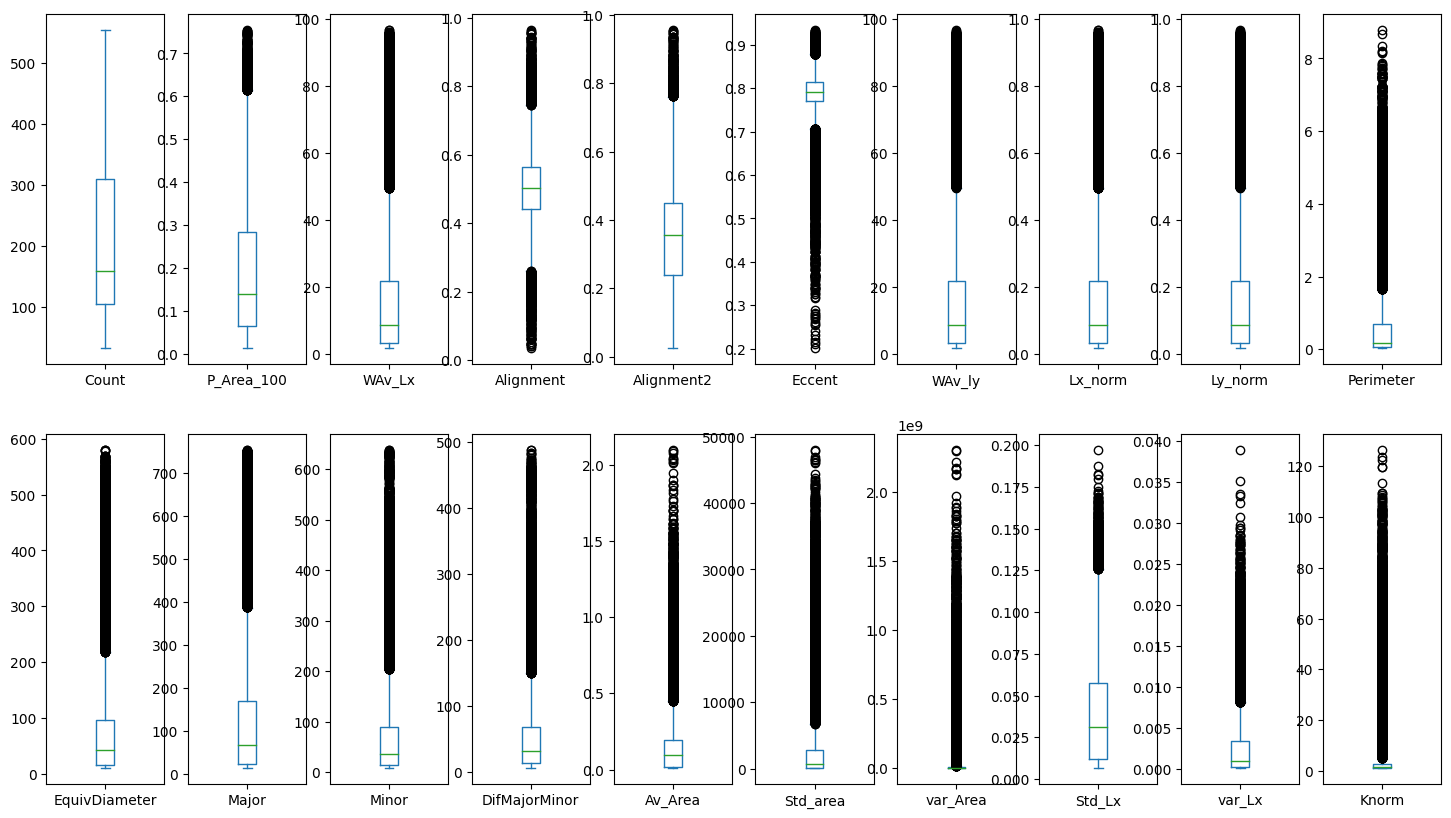

In [25]:
# Boxplots
nolabel_dataset.plot(kind = 'box', subplots = True, layout = (2,10), sharex = False, sharey = False, figsize = (18,10))
plt.show()

Nos gráficos bloxplot, podemos verificar que a dispersão dos atributos do dataset é bem diferente. Há possíveis outliers e as variáveis Keq(m2) e Knorm possuem muitas ocorrências distante da média.

array([<Axes: title={'center': 'P_Area_100'}, xlabel='Threshold'>,
       <Axes: title={'center': 'Knorm'}, xlabel='Threshold'>],
      dtype=object)

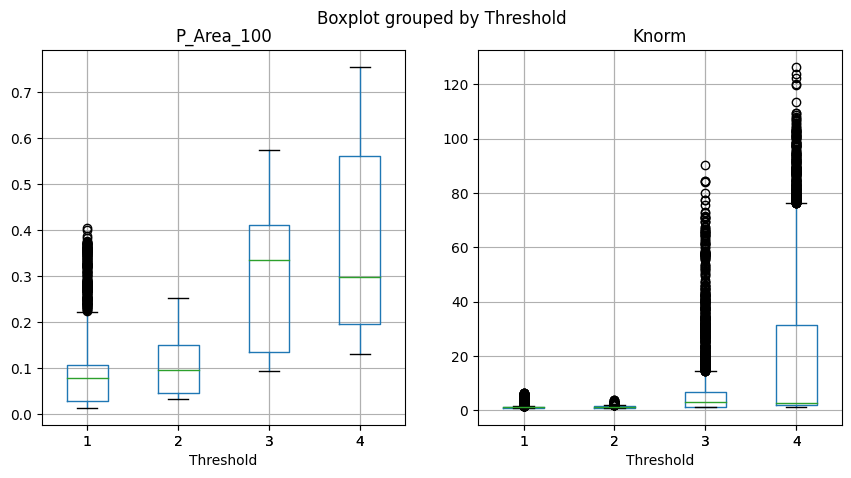

In [29]:
# Boxplots of two variables distributions grouped by the values of a third variable
nolabel_dataset.boxplot(column=['P_Area_100','Knorm'], by='Threshold', layout = (1,2), figsize = (10,5), sharey = False,)

array([<Axes: title={'center': 'P_Area_100'}, xlabel='Sample'>,
       <Axes: title={'center': 'Knorm'}, xlabel='Sample'>], dtype=object)

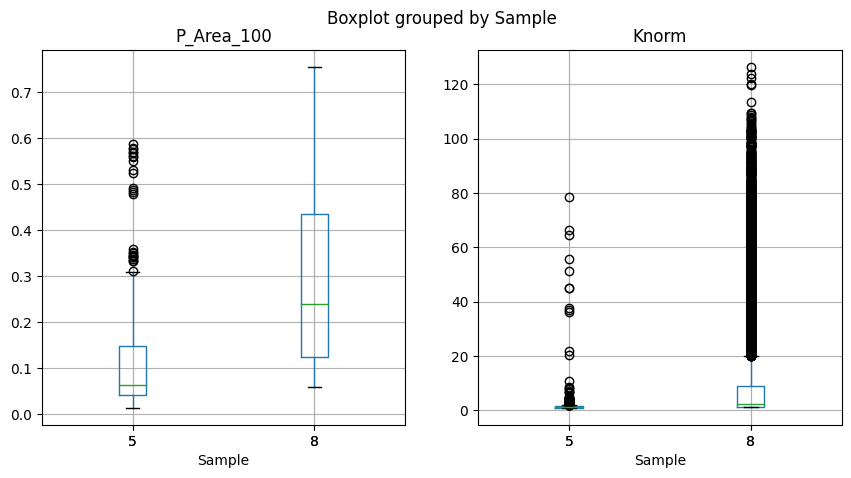

In [30]:
# Boxplots of two variables distributions grouped by the values of a third variable
nolabel_dataset.boxplot(column=['P_Area_100','Knorm'], by='Sample', layout = (1,2), figsize = (10,5), sharey = False,)

Vamos criar uma nova cópia da base de dados sem zeros e valores NaN

No tratamento dos dados foram excluídas 2174 linhas com valores nulos e 14 com dados fora do range de análise.

# 4. Separação em conjunto de treino e conjunto de teste

Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para testar o modelo. Primeiramente, iremos sinalizar quais são as colunas de atributos e qual é a coluna com a variável alvo (Knorm). A coluna Id1 representa o índice e não será utilizada como variável independente X. Para garantir a reprodutibilidade dos resultados, especificou-se uma semente na função. Finalmente, faremos a separação dos dados e 4 conjuntos: conjunto de treino com os atributos, conjunto de treino com a resposta esperada, conjunto de teste com os atributos e conjunto de teste com a resposta esperada.


In [31]:
# Split Train-test-validation set
X_train, X_test, X_val, Y_train, Y_test, Y_val = pre_process.pre_processing(nolabel_dataset, test_size, val_size, random_state)

### 4.1 Normalização e Padronização

Padronizando os dados

In [33]:
#Standard Scaler
X_train_meansc, X_test_meansc, X_val_meansc = pre_process.standardization(X_train, X_test, X_val)

Normalizando os dados

In [34]:
#Min Max Scaler
X_train_rangesc, X_test_rangesc, X_val_rangesc = pre_process.normalization(X_train, X_test, X_val)

#5. Seleção de atributos

In [66]:
feature_selector = FeatureSelection(k_best=10)
X_train_selected, best_var = feature_selector.select_features(X_train_rangesc, Y_train)
X_test_selected = feature_selector.feature_selector.transform(X_test)

#### Método 1: Seleção de atributos com SelectKBest

In [74]:
# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit_Kbest = best_var.fit(X_train_rangesc, Y_train)

In [75]:
#Results Kbest
print('Number of Features:', X_train_selected.shape[1])
print("\nSelected Features: %s" % best_var.get_feature_names_out(input_features=nolabel_dataset.columns[0:-1]))

Number of Features: 10

Selected Features: ['P_Area_100' 'WAv_Lx' 'WAv_ly' 'Lx_norm' 'Ly_norm' 'Perimeter' 'Major'
 'Minor' 'Std_area' 'var_Lx']


Pontuação dos Atributos Originais

In [73]:
# Columns names from dataframe
columns_name = nolabel_dataset.columns.values.tolist()[:-1]
# Ranking of Features
selection_ranking = fit_Kbest.scores_

# Get RFE results to dataframe
table_Kbest = pd.DataFrame(list(zip(nolabel_dataset.columns.values.tolist()[:-1],selection_ranking))).T
table_Kbest['Features'] = ['Originals','Scores']
table_Kbest=table_Kbest.set_index('Features')

# Plot results in table
table_Kbest

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Features,,,,,,,,,,,,,,,,,,,,,
Originals,Count,Sample,Threshold,P_Area_100,WAv_Lx,Alignment,Alignment2,Eccent,WAv_ly,Lx_norm,...,Perimeter,EquivDiameter,Major,Minor,DifMajorMinor,Av_Area,Std_area,var_Area,Std_Lx,var_Lx
Scores,2.31894,3.16438,4.212242,366.387282,263.472946,2.683469,7.782239,9.336289,222.456968,263.472946,...,844.50486,210.069733,259.649334,215.689871,80.669876,96.845825,222.476409,124.961345,67.797027,227.883471


#### Método 2: Seleção de atributos por eliminação recursiva

Avaliação de quantos atributos são necessários para uma boa performance do modelo usando DecisionTree

In [36]:
#Evaluate RFE for regression

# Criação do modelo
model = DecisionTreeRegressor()
models = dict()

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

# Recursive Feature Elimination
# get a list of parameters to evaluate
for i in range(2,13):
  rfe = RFE(model, n_features_to_select=i)
  # create pipeline
  models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])

results, names = list(),list()
for name, model in models.items():
  # evaluate the models
  scores = evaluate_model(model, X_train, Y_train)
  # Store results
  results.append(scores)
  names.append(name)
  # Report performance
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 -2.142 (0.195)
>3 -1.720 (0.177)
>4 -1.554 (0.134)
>5 -1.470 (0.121)
>6 -1.430 (0.129)
>7 -1.381 (0.143)
>8 -1.336 (0.131)
>9 -1.316 (0.120)
>10 -1.312 (0.120)
>11 -1.304 (0.121)


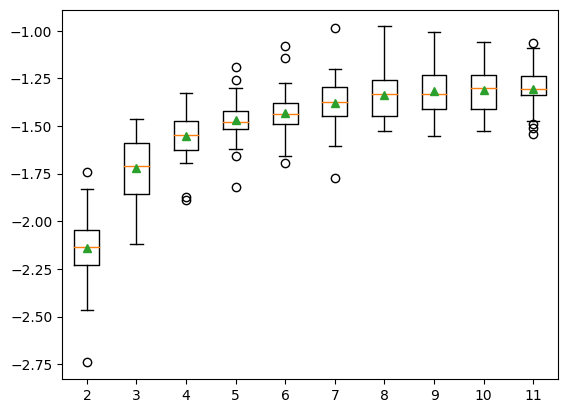

In [37]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Após testar a quantidade de features pela performance de um modelo, escolhemos somente 7 atributos como sendo um número relevante para encontrar o alvo.

In [78]:
# Recursive Feature Elimination with 7 features
model = DecisionTreeRegressor()
rfe = RFE(model, n_features_to_select=7)

fit_rfe = rfe.fit(X_train, Y_train)

Pontuação dos atributos originais usando RFE

In [80]:
# Columns names from dataframe
columns_name = nolabel_dataset.columns.values.tolist()[:-1]
#Features Selected
selection_features = fit_rfe.support_
# Ranking of Features. If 1 the feature was selected
selection_ranking = fit_rfe.ranking_

# Get RFE results to dataframe
table_rfe = pd.DataFrame(list(zip(columns_name,selection_features, selection_ranking))).T
table_rfe['Features'] = ['Originals','Selected','Ranking']
table_rfe=table_rfe.set_index('Features')

In [81]:
# Plot results in table
table_rfe

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Features,,,,,,,,,,,,,,,,,,,,,
Originals,Count,Sample,Threshold,P_Area_100,WAv_Lx,Alignment,Alignment2,Eccent,WAv_ly,Lx_norm,...,Perimeter,EquivDiameter,Major,Minor,DifMajorMinor,Av_Area,Std_area,var_Area,Std_Lx,var_Lx
Selected,False,False,False,True,True,True,True,False,False,False,...,False,False,True,True,False,False,False,False,True,False
Ranking,7,15,11,1,1,1,1,3,14,8,...,6,2,1,1,4,12,13,10,1,5


Atributos selecionados com o método de eliminação recursiva

In [82]:
print("Number of Features: %d" % fit_rfe.n_features_)
print("\nSelected Features: %s" % fit_rfe.get_feature_names_out(input_features=nolabel_dataset.columns[0:-1]))

Number of Features: 7

Selected Features: ['P_Area_100' 'WAv_Lx' 'Alignment' 'Alignment2' 'Major' 'Minor' 'Std_Lx']


#### Método 3: Importância dos atributos pela árvore de decisão

In [85]:
# Selecting training model
dt_model = select_model.generic_train(DecisionTreeRegressor(), X_train_rangesc, Y_train)

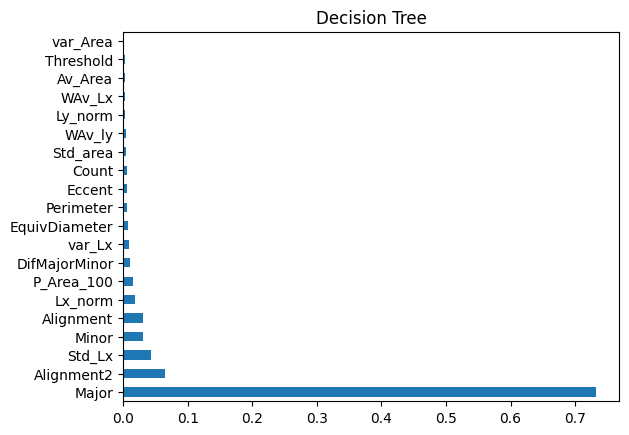

In [99]:
feat_importances_dt = pd.Series(dt_model.feature_importances_, index=nolabel_dataset.columns[0:-1])
feat_importances_dt.nlargest(20).plot(kind='barh')
plt.title('Decision Tree')
plt.show()

In [91]:
# Selecting another training model
extra_model = select_model.generic_train(ExtraTreesRegressor(), X_train, Y_train)

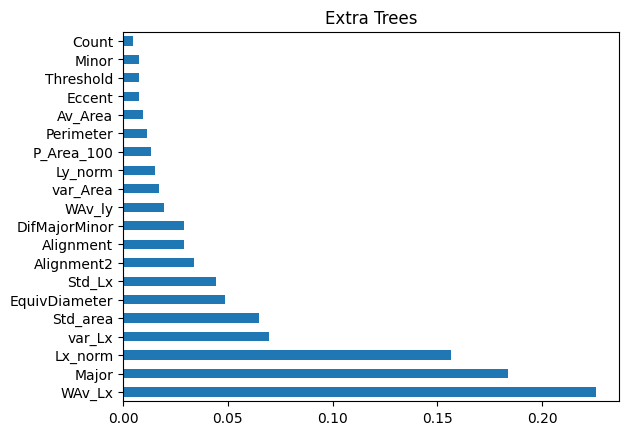

In [92]:
feat_importances_extra = pd.Series(extra_model.feature_importances_, index=nolabel_dataset.columns[0:-1])
feat_importances_extra.nlargest(20).plot(kind='barh')
plt.title('Extra Trees')
plt.show()

**Resumo da seleção de atributos**

KBest:  ['P_Area_100' 'WAv_Lx' 'WAv_ly' 'Lx_norm' 'Ly_norm' 'Perimeter' 'Major'
 'Minor' 'Std_area' 'var_Lx']

RFE:  ['P_Area_100' 'WAv_Lx' 'Alignment' 'Alignment2' 'Major' 'Minor' 'Std_Lx']


<Axes: >

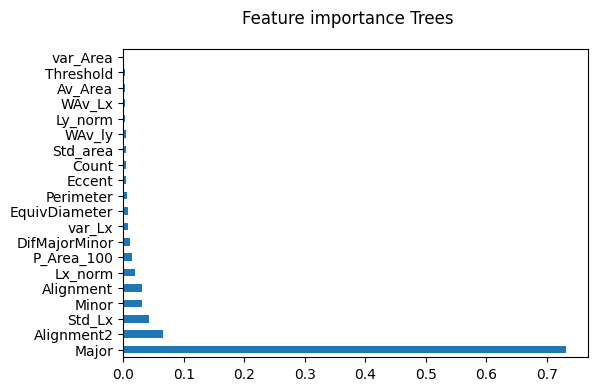

In [117]:
# 1. KBest
print("KBest: ",best_var.get_feature_names_out(input_features=nolabel_dataset.columns[0:-1]))

# 2. Recursive Feature Elimination
print("\nRFE: ", fit_rfe.get_feature_names_out(input_features=nolabel_dataset.columns[0:-1]))

# 3. Feature importance Trees
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle('Feature importance Trees')
feat_importances_dt = pd.Series(dt_model.feature_importances_, index=nolabel_dataset.columns[0:-1])
feat_importances_dt.nlargest(20).plot(ax=ax,kind='barh')

#feat_importances_extra = pd.Series(extra_model.feature_importances_, index=nolabel_dataset.columns[0:-1])
#feat_importances_extra.nlargest(20).plot(ax=ax2,kind='barh')

Com os 3 métodos de seleção de atributos escolhemos os que foram escolhas comuns em pelo menos dois métodos.

Os atributos selecionados foram:

['P_Area_100' 'WAv_Lx' 'Major' 'Minor' 'Alignment2' 'Std_Lx' 'Lx_norm']

#### Restringindo os atributos da base de dados

Seleção das colunas baseado nos atributos escolhidos

In [184]:
# Get selected feature columns
selected_dataset = nolabel_dataset[['P_Area_100','WAv_Lx','Major','Minor','Alignment2','Std_Lx','Lx_norm','Knorm']]

Separação da base de dados em treino-teste-validação

In [185]:
# Split Train-test-validation set from new dataset
X_selec_train, X_selec_test, X_selec_val, Y_selec_train, Y_selec_test, Y_selec_val = pre_process.pre_processing(selected_dataset, test_size, val_size, random_state)

Normalização dos dados

In [186]:
#Min Max Scaler from new dataset
X_selec_train_rangesc, X_selec_test_rangesc, X_selec_val_rangesc = pre_process.normalization(X_selec_train, X_selec_test, X_selec_val)

Um novo dataset foi criado após a seleção dos 7 atributos relevantes para treinamento e nova avaliação do modelo.

# 6. Modelo

Avaliação de vários modelos em partições da validação cruzada

In [165]:
# Global seed
np.random.seed(42)
# Create folds to cross validation
n_cv = 5 # number of folds in cross validation
kfold = KFold(n_splits=n_cv, shuffle=True, random_state=42) # partitioning

In [137]:
# Parameters
num_trees = 100
max_features = 3

In [156]:
# Models list to train
models = []

# Preparing holdout
models.append(('LR', LinearRegression()))
models.append(('Extra', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Decision', DecisionTreeRegressor(max_features=max_features)))
models.append(('XGB', XGBRegressor(n_estimators=num_trees)))
models.append(('Grad', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('LGBM', LGBMRegressor(n_estimators=num_trees)))
#models.append(('SVM', SVR(max_iter=200)))
#models.append(('SGD', SGDRegressor(max_iter=200)))
models.append(('Ridge', Ridge(max_iter=200)))
models.append(('Lasso', Lasso(max_iter=200)))
models.append(('KNN', KNeighborsRegressor()))

In [157]:
# Bagging Regressor
# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeRegressor()

In [158]:
models.append(('Bagging', BaggingRegressor(base_estimator=base, n_estimators=num_trees)))

In [159]:
# Criando os modelos para o VotingClassifier
bases = []
model1 = RandomForestRegressor()
bases.append(('forest', model1))
model2 = ExtraTreesRegressor()
bases.append(('extra', model2))
model3 = GradientBoostingRegressor()
bases.append(('gb', model3))

In [160]:
models.append(('Voting', VotingRegressor(bases)))

In [161]:
# Evaluate a bunch of models using cross validation
# Original data
(model_names_orig, results_orig) = select_model.train_models(models, X_selec_train, Y_selec_train, kfold)

Model:	 MAE_mean	 (MAE_std)

LR: 4.488620 (0.102237)
Extra: 1.057443 (0.059622)
Decision: 1.398480 (0.090025)
XGB: 1.183952 (0.055480)
Grad: 1.401004 (0.070981)
RF: 1.087711 (0.055791)
LGBM: 1.173422 (0.062852)
Ridge: 4.665406 (0.101214)
Lasso: 4.787240 (0.140714)
KNN: 1.929091 (0.123826)
Bagging: 1.060180 (0.045299)
Voting: 1.112157 (0.053194)


In [162]:
# Evaluate a bunch of models using cross validation
# Data with Normalization
(model_names_range, results_range) = select_model.train_models(models, X_selec_train_rangesc, Y_selec_train, kfold)

Model:	 MAE_mean	 (MAE_std)

LR: 4.488620 (0.102237)
Extra: 1.054016 (0.057540)
Decision: 1.410728 (0.050321)
XGB: 1.183870 (0.055455)
Grad: 1.401201 (0.071099)
RF: 1.091672 (0.051995)
LGBM: 1.176686 (0.060782)
Ridge: 4.451757 (0.104539)
Lasso: 4.327214 (0.140564)
KNN: 1.068045 (0.052434)
Bagging: 1.058425 (0.046922)
Voting: 1.116134 (0.055929)


#### Comparação dos modelos

Boxplot de comparação dos modelos

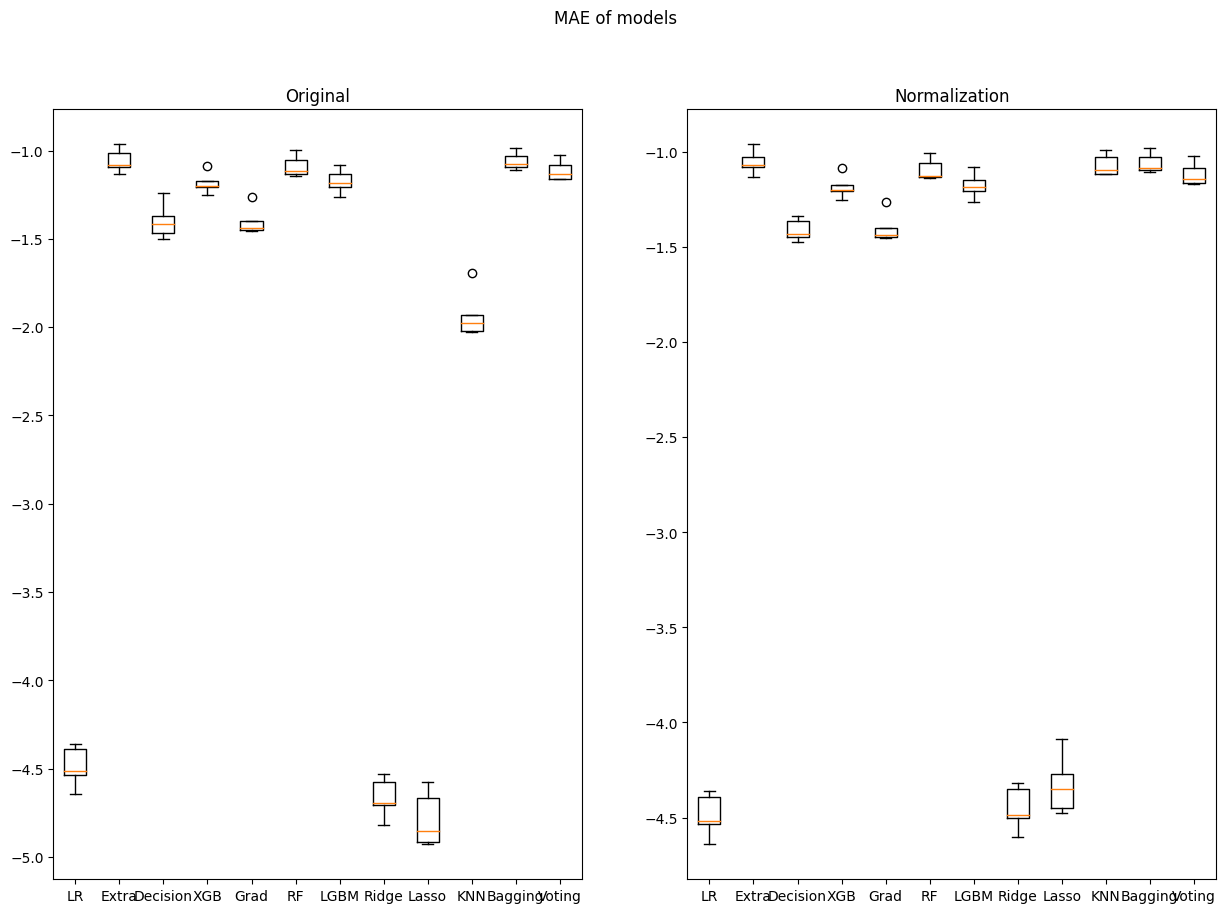

In [163]:
# Model comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('MAE of models')
ax1 = fig.add_subplot(121)
# Boxplot
plt.boxplot(results_orig)
ax1.set_xticklabels(model_names_orig)
ax1.title.set_text("Original")

ax2 = fig.add_subplot(122)
# Boxplot
plt.boxplot(results_range)
ax2.set_xticklabels(model_names_range)
ax2.title.set_text("Normalization")

plt.show()

### 5.1 Otimização dos hiperparâmetros

Busca dos hiperparâmetros para a regressão utilizando XGBoosting

In [203]:
pipelines = []

# Definindo os componentes do pipeline
xgb = ('XGBR', XGBRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('xgbr-orig', Pipeline(steps=[xgb])))
pipelines.append(('xgbr-padr', Pipeline(steps=[standard_scaler, xgb])))
pipelines.append(('xgbr-norm', Pipeline(steps=[min_max_scaler, xgb])))

param_grid = {
    'XGBR__learning_rate': [.03, 0.05, .07],
    'XGBR__n_estimators' : [50,100,500],
    'XGBR__max_depth'    : [4,6,8]
}
ind = 0
for name, model in pipelines:
    ind += 1
    grid_estimator, grid_score, grid_params = select_model.hyperparameter_tuning(model,X_selec_train, Y_selec_train, param_grid, kfold)
    print("\nResults from Grid Search ", ind)
    print("\n The best estimator across ALL searched params:\n",grid_estimator)
    print("\n The best score across ALL searched params:\n",grid_score)
    print("\n The best parameters across ALL searched params:\n",grid_params)


Results from Grid Search  11

 The best estimator across ALL searched params:
 Pipeline(steps=[('XGBR',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=500,
                 

Serão utilizados os parametros após busca pela função `GridSearchCV` com os dados normalizados:

 {'XGBR__learning_rate': 0.05, 'XGBR__max_depth': 8, 'XGBR__n_estimators': 500}

# 7. Avaliação do Modelo

Utilizando o modelo XGBRegressor e analisando a importância de cada variável no modelo

In [204]:
# Selecting training model
xgb_model = select_model.generic_train(XGBRegressor(learning_rate= 0.05, max_depth= 8, n_estimators= 500), X_selec_train_rangesc, Y_selec_train)

Score do modelo com os parametros provenientes do GridSearchCV

In [205]:
# Model score
xgb_prediction = evaluation.eval_accuracy(xgb_model, X_selec_test_rangesc, Y_selec_test)

MAE:1.03	 MSE:13.02	 RMSE:3.61	 R2:0.94



Comparando a predição com o valor original

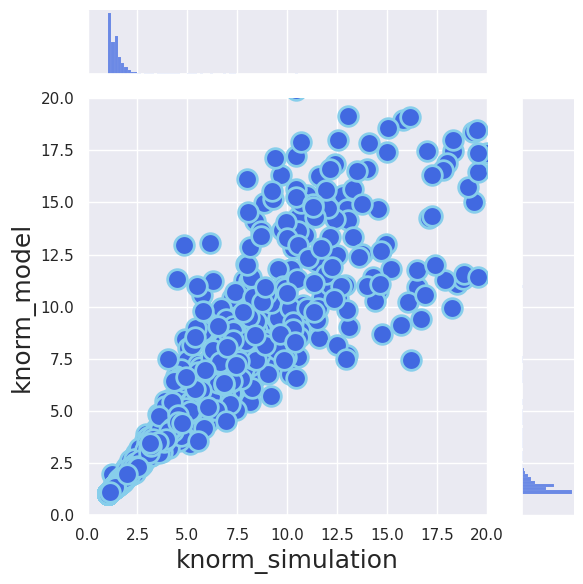

In [206]:
# Draw a plot of two variables
sns.set(font_scale=1.0)
df = pd.DataFrame({'simulation':Y_selec_test,'prediction': xgb_prediction})
sns_plot = sns.jointplot(data=df,x='simulation',y='prediction', kind='scatter', s=200, color="royalblue", edgecolor="skyblue", linewidth=2)
sns_plot.set_axis_labels('knorm_simulation', 'knorm_model', fontsize=18)

# Set axis limit
sns_plot.ax_marg_x.set_xlim(0, 20)
sns_plot.ax_marg_y.set_ylim(0, 20)

# labels appear outside of plot area, so auto-adjust
sns_plot.figure.tight_layout()

# 8. Avaliação do modelo em dados não vistos

In [207]:
# Model score for validation set
val_prediction = evaluation.eval_accuracy(xgb_model, X_selec_val_rangesc, Y_selec_val)

MAE:1.01	 MSE:12.25	 RMSE:3.50	 R2:0.95



Comparando a predição com o valor esperado para o conjunto de validação

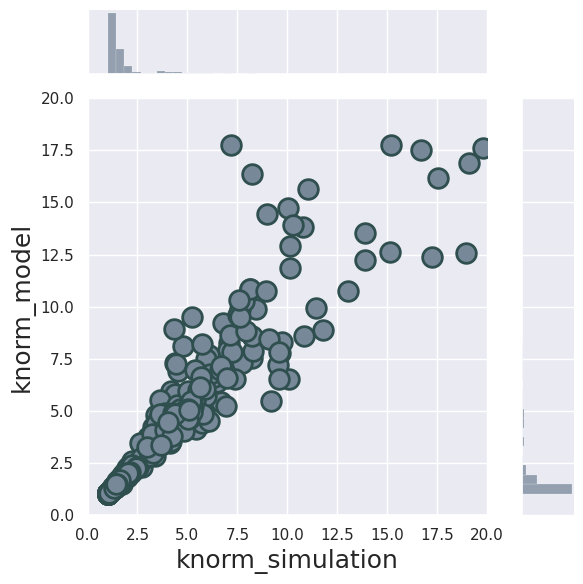

In [208]:
# Draw a plot of two variables
sns.set(font_scale=1.0)
df = pd.DataFrame({'simulation':Y_selec_val,'prediction': val_prediction})
sns_plot = sns.jointplot(data=df,x='simulation',y='prediction', kind='scatter', s=200, color="lightslategrey", edgecolor="darkslategrey", linewidth=2)
sns_plot.set_axis_labels('knorm_simulation', 'knorm_model', fontsize=18)

# Set axis limit
sns_plot.ax_marg_x.set_xlim(0, 20)
sns_plot.ax_marg_y.set_ylim(0, 20)

# labels appear outside of plot area, so auto-adjust
sns_plot.figure.tight_layout()

#**Conclusão do modelo**

A base de dados original possuía 21 atributos.
A seleção de atributos mostrou que com 7 variáveis independentes o modelo conseguiria obter uma boa performance.
O modelo de regressão apresentou uma acurácia satisfatória para o conjunto de teste. As váriaveis independentes foram suficientes para uma boa predição do modelo de regressão, principalmente para `Knorm <10`. Esse resultado melhor se encontra onde a variabilidade dos dados é menor.